# Vision Transformer (ViT) for facial image classification based on gender

## Prerequisites
1. Linux OS
2. Conda Environment installed according to the steps from https://github.com/pgagarinov/pytorch-hyperlight/blob/main/products/jupyterlab-ml-devenv/README.md
3. PyTorch-Hyperlight package `pip install pytorch-hyperlight`

In [1]:
import math
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pytorch_hyperlight as pth
import pytorch_pretrained_vit
import torch
import torchvision
from efficientnet_pytorch import EfficientNet
from pytorch_hyperlight.datasets.kaggle.utkfaces import UTKFacesDataLoadersBuilder
from pytorch_hyperlight.tasks.classification import (
    AAutoClsHeadClassificationTaskWDAdamWStepLR,
)
from pytorch_hyperlight.utils.image_utils import show_image_tensors
import torch.nn as nn

In [2]:
FAST_DEV_RUN = False  # if true, simplifed configurations running for just a few epochs are used for making sure there are no obvious bugs

## Loading data from UTKFace dataset

Let us look at the data after all the data augmentation transformations

In [3]:
EXPERIMENT_ID = "vit-utk-faces"

In [4]:
SEED = 16

In [18]:
if "workbookDir" not in globals():
    workbookDir = os.getcwd()
WORKBOOK_DIR = Path(workbookDir)

In [19]:
dataloaders_builder = UTKFacesDataLoadersBuilder(
    seed=SEED,
    root_path=WORKBOOK_DIR / "datasets",
    label_field="gender"
)

In [20]:
IMAGE_SIZE = dataloaders_builder.get_image_size()

In [21]:
f_create_dataloaders, f_create_datasets = dataloaders_builder.build()

In [22]:
warnings.filterwarnings("ignore")

In [23]:
BATCH_SIZE = 32

loaders_dict = f_create_dataloaders(BATCH_SIZE)

loaders_dict

batch = next(iter(loaders_dict["test_loader"]))
assert len(batch[0]) > 0

Global seed set to 16


In [24]:
dataset_dict = f_create_datasets()

Global seed set to 16


In [25]:
train_show_full_augmented_dataset = loaders_dict["train_show_full_augmented_dataset"]

In [26]:
class_inds2labels = train_show_full_augmented_dataset.class_inds2labels
class_ind2label = train_show_full_augmented_dataset.class_ind2label

In [27]:
random_sample_vec = np.random.choice(len(train_show_full_augmented_dataset), 10)

In [28]:
img_list, class_ind_list = zip(
    *[train_show_full_augmented_dataset[ind] for ind in random_sample_vec]
)

In [29]:
label_list = train_show_full_augmented_dataset.class_inds2labels(class_ind_list)

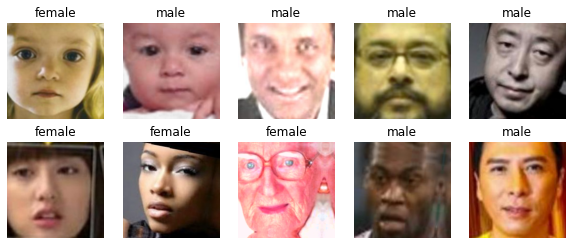

In [30]:
show_image_tensors(img_list, title_list=label_list, max_cols=5)

In [31]:
def show_class_imbalance(dataset_dict):
    fig, ax = plt.subplots(1, figsize=(10, 7))
    plt_list = []
    title_list = []
    dataset_name_len_list = [
        [k, len(v)] for k, v in dataset_dict.items() if k.endswith("_dataset")
    ]

    for dataset_field, dataset_len in dataset_name_len_list:
        dataset = loaders_dict[dataset_field]
        unique_labels, unique_counts = np.unique(
            dataset.get_labels(), return_counts=True
        )
        unique_labels = class_inds2labels(unique_labels)
        plt_obj = ax.bar(unique_labels, unique_counts)
        plt_list.append(plt_obj)
        title_list.append(f"{dataset_field}: {dataset_len}")

    plt.title("Class Frequency")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.legend(plt_list, title_list)
    plt.show()

In [32]:
dataset_dict = f_create_datasets()

Global seed set to 16


Let us see well-balanced our classes are

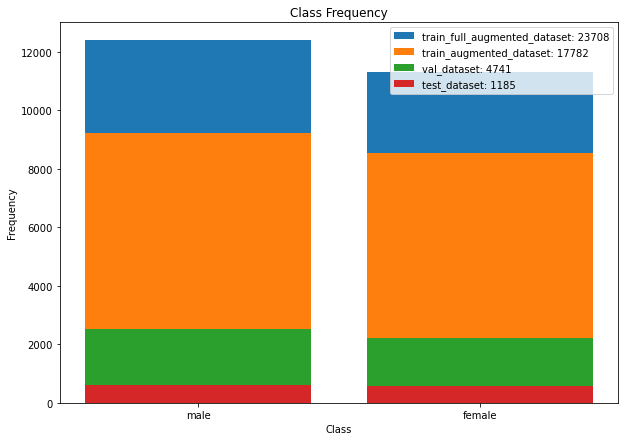

In [33]:
show_class_imbalance(
    {
        k: v
        for k, v in dataset_dict.items()
        if not ("inference" in k or "show" in k)
    }
)

As we can see, the classes are well-balanced which means we can safely use accuracy as a model quality metrics.

### Vision Transformer vs EfficientNet

Let us use our training set to fine-tune both Vision Transformer "B_16_imagenet1k" (which is pretrained on "ImageNet-21k" and fine-tuned on "ImageNet-1k") from [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) GitHub project and EfficientNet-B7 from [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch) GitHub project.

We'll use a double-layered FC classification head with biases initialized with zeros to make sure we do not introduce any unnecessary bias to the transformers heads. Dropout between the layeres should help with overfitting.

Since we will compare Vision Transformer and EfficientNet under the same settings we can safely use the same metrics calculation logic, criterions and optimizers. All this is mostly implemented in a reusable `AAutoClsHeadClassificationTaskWDAdamWStepLR` class imported from PyTorch-Hyperlight. 

In [19]:
N_CLASSES = loaders_dict["n_classes"]
IS_CUDA = torch.cuda.is_available()
GPU_PER_TRIAL = 0.3 * IS_CUDA

We use batch size = 16 for both compared models. In fact, ViT allows for maximum batch size = 32 for this particular task and RTX 2070 8Gb GPU with 16bit precision. The maximum batch size for EfficientNet on the same hardware is 16. However we do not want the batch size to be different for different models as it might impact model performance.

In [20]:
CONFIG = {
    "classifier_lr": 1e-3,
    "rest_lr": 1e-5,
    "step_lr_gamma": 0.6,
    "step_lr_step_size": 1,
    "classifier_dropout": 0.2,
    "gradient_clip_val": 2,
    "max_epochs": 10,  # the actual number can be less due to early stopping
    "batch_size": 16,
    "no_weight_decay_param_names": ["bias", "LayerNorm.weight"],
    "weight_decay": 0,
    "n_classes": N_CLASSES,
}

EXTRA_CONFIG = {
    "seed": SEED,  # just remove this if you do not want determenistic behavior
    "metric_to_optimize": "val_f1_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_f1_epoch",
        "val_acc_epoch",
    ],  # for Ray Tune
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    "gpu_per_trial": GPU_PER_TRIAL,  # for Ray Tune
    "n_checkpoints_to_keep": 1,  # for Ray Tune
    "grace_period": 0,  # for both PTL Trainer and Ray Tune scheduler
    "epoch_upper_limit": 45,  # for Ray Tune
    "n_samples": 3,  # for Ray Tune
    "ptl_early_stopping_patience": 3,  # for PTL Trainer
    "ptl_precision": 16,  # or 16, for PTL Trainer
    "train_loader_name": "train_augmented_loader",
    "val_loader_name": "val_loader",
    "test_loader_name": "test_loader",
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for revalidation and test phases
    #    that run in the main process after all Ray Tune child processes are finished
    "gpus": -1 * IS_CUDA,  # -1 - use GPU if available, 0 - use CPU, 1 - use single GPU,
    # >=2 - use multiple GPUs
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    EXTRA_CONFIG["n_samples"] = 2

The `Runner` class from PyTorch-Hyperlight hides all the technicalities related to training, validation and testing of the model. 

In [21]:
runner = pth.Runner(
    f_create_dataloaders,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
    log2wandb=False,
)

We will use `run_single_trial` method of `Runner` to run a single `trial` i.e a single cycle of training-validation-testing. Please note that we do not pass an instance of our PyTorch-Lightning module into `Runner`. Instead we just pass a class name of our model and let `Runner` instantiate the module by itself.

### EfficientNet-B7 fine-tuning

In [23]:
class EfficientNetClassifier(AAutoClsHeadClassificationTaskWDAdamWStepLR):
    def __init__(self, hparams):
        model_name = hparams["model_name"]
        model = EfficientNet.from_pretrained(model_name)
        criterion = nn.CrossEntropyLoss()
        super().__init__(hparams, model, criterion)

    def _get_classifier_module_name(self):
        return "_fc"

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16


Loaded pretrained weights for efficientnet-b7


Global seed set to 16

  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | EfficientNet     | 70.3 M
1 | criterion         | CrossEntropyLoss | 0     
2 | train_metric_calc | LitMetricsCalc   | 0     
3 | val_metric_calc   | LitMetricsCalc   | 0     
4 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
70.3 M    Trainable params
0         Non-trainable params
70.3 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

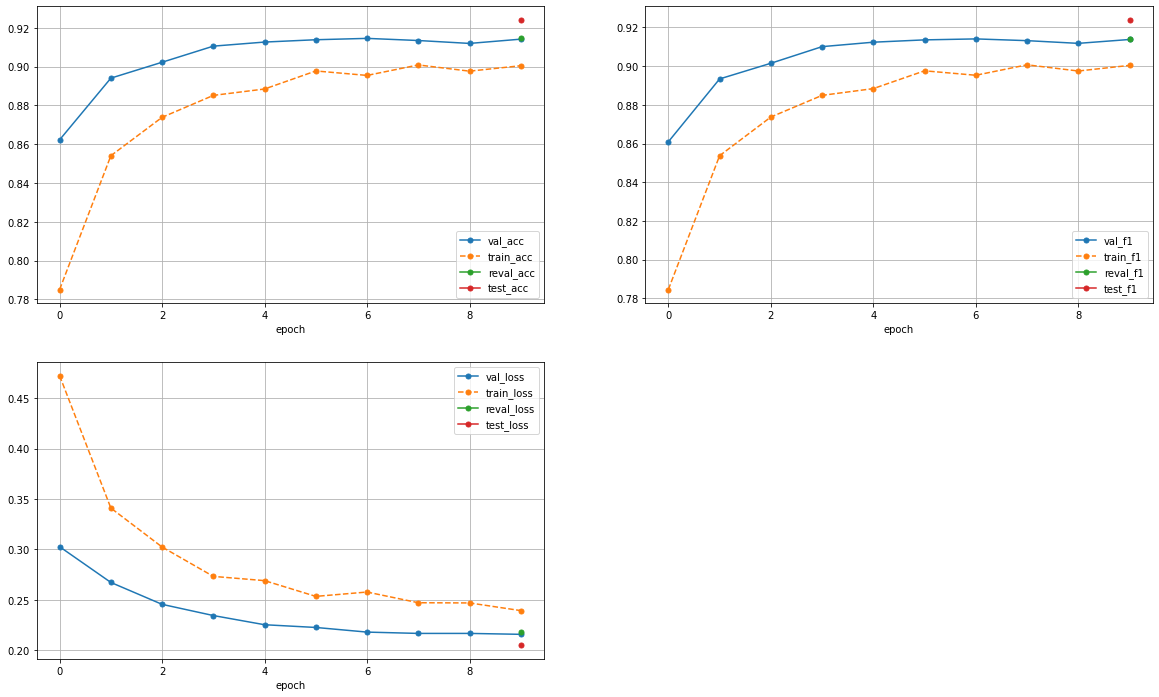

Loaded pretrained weights for efficientnet-b7


Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [35]:
config = CONFIG.copy()
config["model_name"] = "efficientnet-b7"
config["gradient_clip_val"] = 2
best_result = runner.run_single_trial(
    EfficientNetClassifier, config, EXTRA_CONFIG, extra_run_name_prefix="clip-"
)

### ViT fine-tuning

Based on various experiments ViT seem to work betweet without gradient clipping while EfficientNet seems to work better with the gradient clipping turned on.

In [22]:
class ViTClassifier(AAutoClsHeadClassificationTaskWDAdamWStepLR):
    def __init__(self, hparams):
        model_name = hparams["model_name"]
        model = pytorch_pretrained_vit.ViT(
            model_name, image_size=IMAGE_SIZE, pretrained=True
        )
        criterion = nn.CrossEntropyLoss()
        super().__init__(hparams, model, criterion)

    def _get_classifier_module_name(self):
        return "fc"

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])


Global seed set to 16


Loaded pretrained weights.



  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | ViT              | 86.4 M
1 | criterion         | CrossEntropyLoss | 0     
2 | train_metric_calc | LitMetricsCalc   | 0     
3 | val_metric_calc   | LitMetricsCalc   | 0     
4 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
86.4 M    Trainable params
0         Non-trainable params
86.4 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

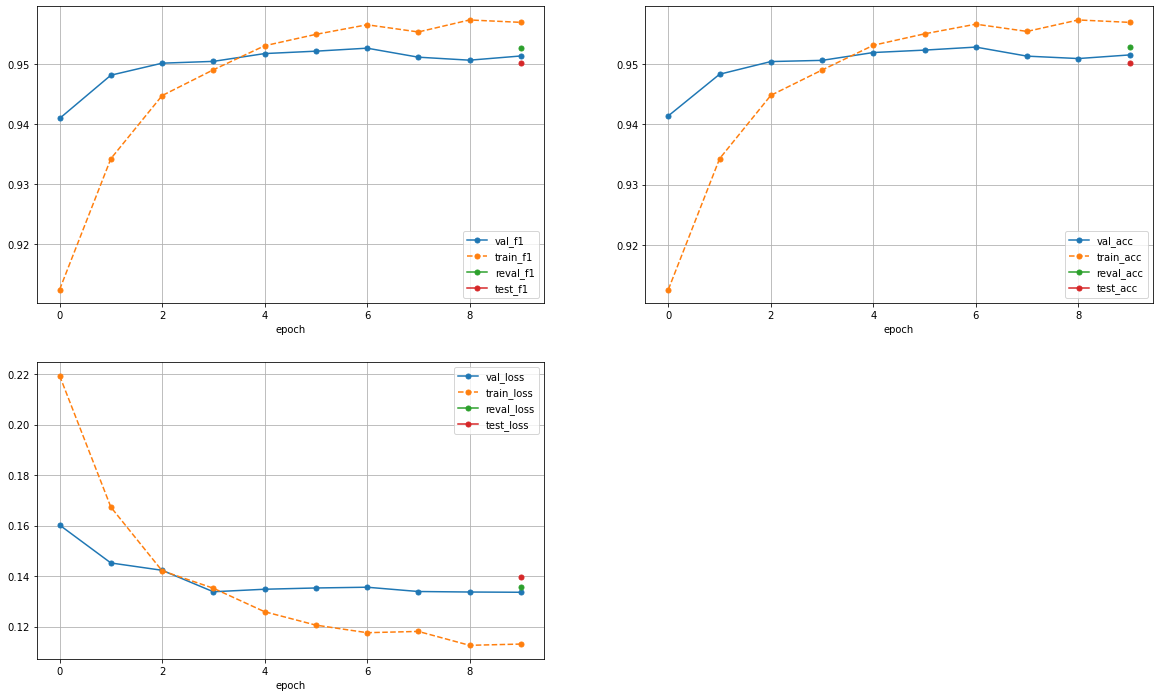

Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])


Global seed set to 16


Loaded pretrained weights.


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [23]:
config = CONFIG.copy()
config["model_name"] = "B_16_imagenet1k"
config["gradient_clip_val"] = 0
best_result = runner.run_single_trial(
    ViTClassifier, config, EXTRA_CONFIG, extra_run_name_prefix="noclip-"
)

,test_f1,test_acc,run
11,0.9502,0.9502,noclip-single-trial-ViTClassifier
11,0.9239,0.9241,clip-single-trial-EfficientNetClassifier


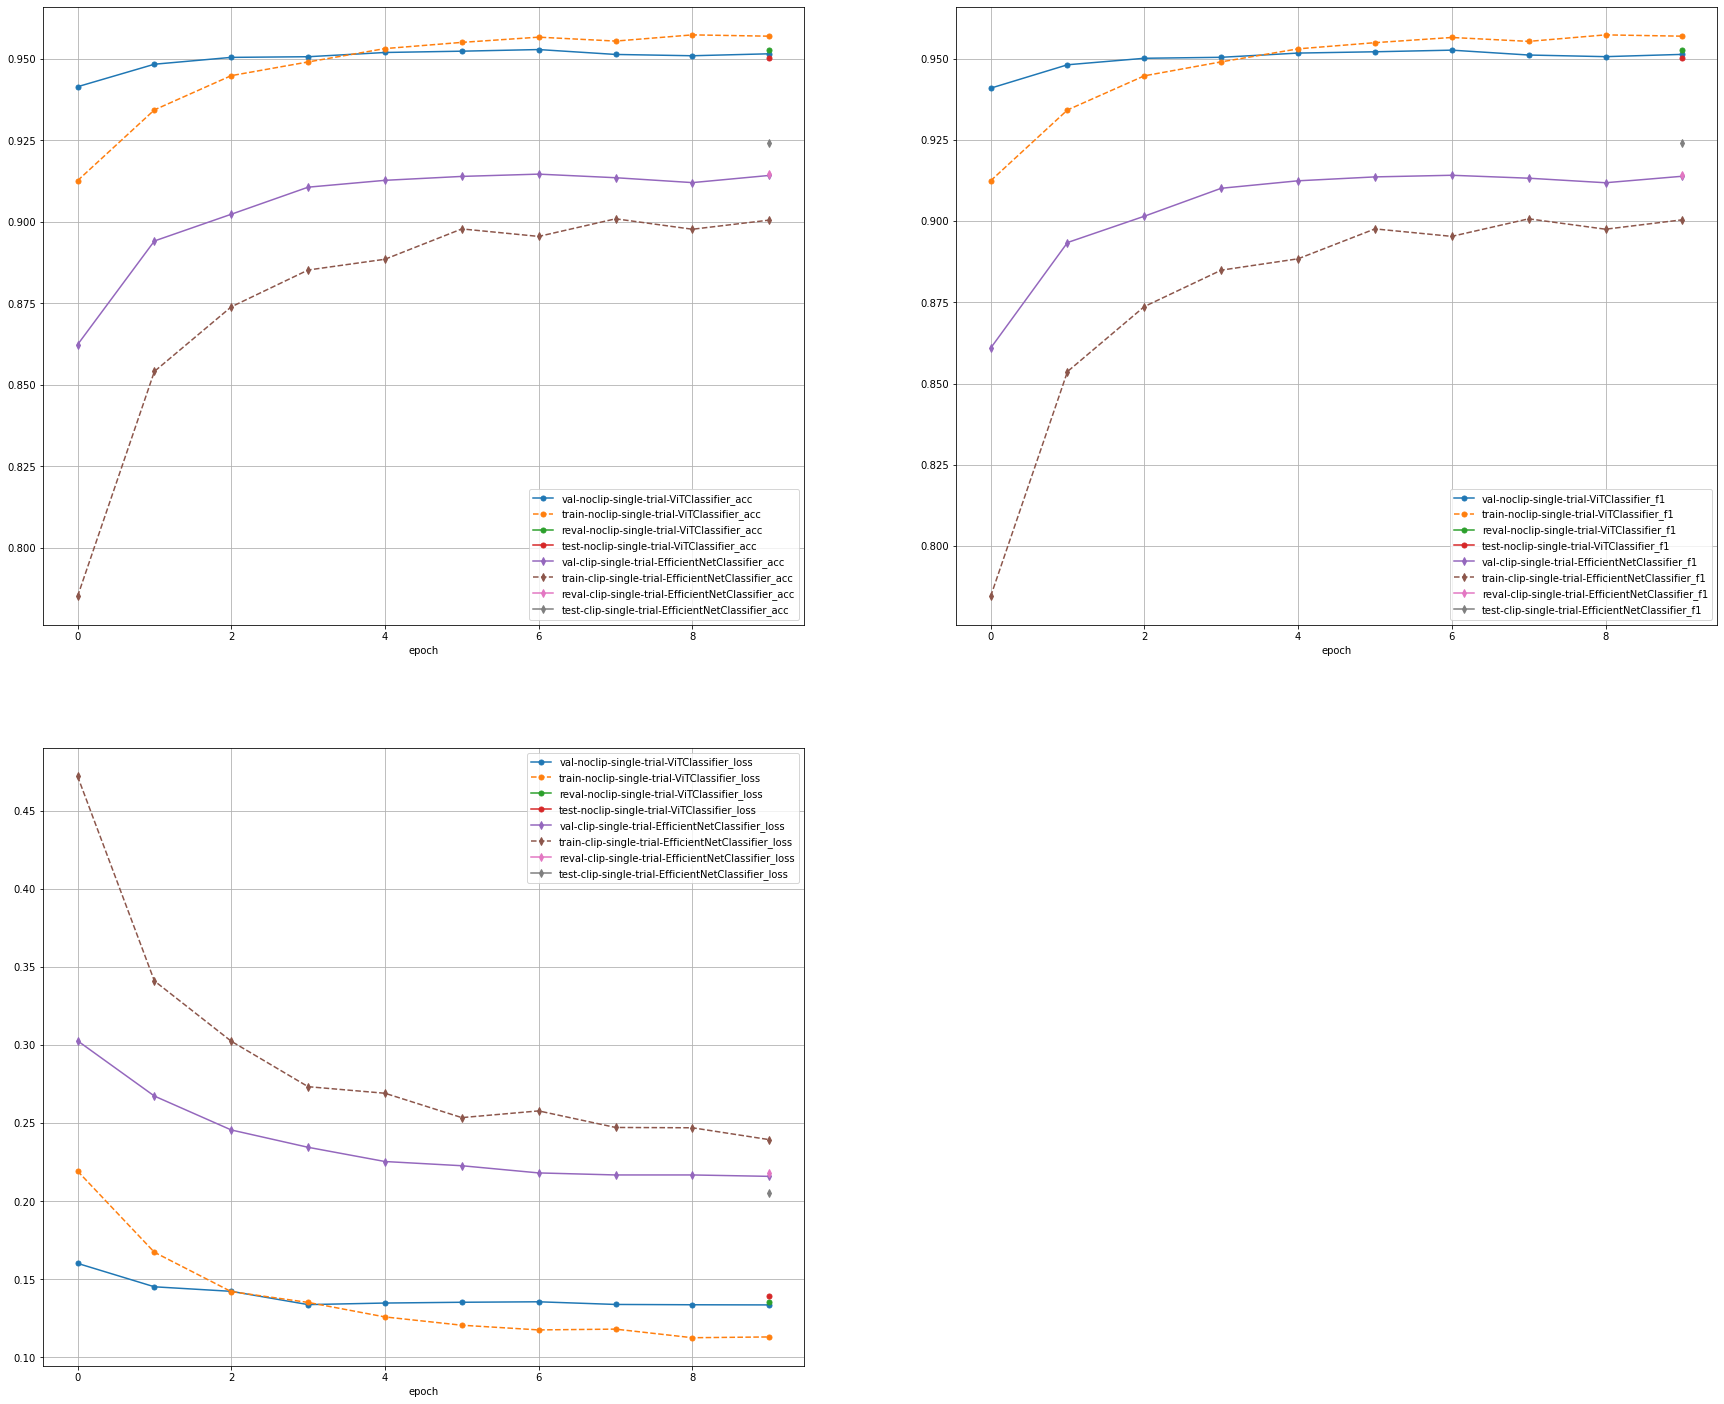

In [36]:
runner.show_metric_report(sort_by_metric_list=["test_f1", "test_acc"], figsize=(30, 25))

### ViT vs EfficientNet: conclusion

1. ViT is approximately 5 times faster than EfficientNet in training (with equal batch sizes) and 4 times faster in inference.
2. ViT is more memory efficient (allows for 2 times larger batch sizes) which makes it even more computationally efficient.
3. ViT provides higher accuracy of 95% vs EfficientNet's 92.5% for this particular dataset and hyperparameter values. 

## Attention analysis

ViT implementation from [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) GitHub project contains built-in mechanism to capture the attention scores generated on each of the transformer levels inside "scores" attribute of `MultiHeadedSelfAttention` PyTorch module:

```
class MultiHeadedSelfAttention(nn.Module):
    """Multi-Headed Dot Product Attention"""
    def __init__(self, dim, num_heads, dropout):
        super().__init__()
        self.proj_q = nn.Linear(dim, dim)
        self.proj_k = nn.Linear(dim, dim)
        self.proj_v = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)
        self.n_heads = num_heads
        self.scores = None # for visualization
```        
We will use this "scores" files to extract attention maps from each level.

In [24]:
lmodule = best_result["lmodule_best"]

In [25]:
model = lmodule.model.eval()

We will visualize cumulative attention maps calculated as cumulative product of all maps from the first level up to Nth level of the transformer.

In [26]:
def calc_cumulative_attention(input_tensor, model):
    logits = model(input_tensor.unsqueeze(0))

    att_mat_list = [block.attn.scores for block in model.transformer.blocks]

    att_mat = torch.stack(att_mat_list).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1), device=att_mat.device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size(), device=aug_att_mat.device)
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])

    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    cumul_att_mask_list = []
    # Attention from the output token to the input space.
    for v in joint_attentions:
        att_mask = v[0, 1:].reshape(grid_size, grid_size).detach()
        img_size = input_tensor.shape[1:]
        att_mask_resized = torch.nn.functional.interpolate(
            att_mask.unsqueeze(0).unsqueeze(0), img_size, mode="bilinear"
        )
        cumul_att_mask_list.append(att_mask_resized)
    return cumul_att_mask_list, logits

In [27]:
def show_attention(input_tensor, att_mask):
    att_mask_normalized = att_mask / att_mask.max()
    result = att_mask_normalized * input_tensor
    show_image_tensors(
        [input_tensor, result, att_mask_normalized],
        ["Original", "Attention*Original", "AttentionMap"],
        figsize=(10, 30),
        cmap="gray",
    )

In [28]:
def show_prediction(logits, ind_class_true):
    N_MAX_CLASSES = 5
    label_true = class_ind2label(ind_class_true)
    probs = torch.nn.Softmax(dim=-1)(logits)
    class_ind_sorted = torch.argsort(probs, dim=-1, descending=True)
    print(f"Real label: {label_true}", end=" | ")
    print("Prediction: ", end="")
    for idx in class_ind_sorted[0, :N_MAX_CLASSES]:
        print(
            f"{class_ind2label(idx.item())} : {probs[0, idx.item()]:.5f}",
            end=" ",
        )

In [29]:
def show_attentions_and_prediction(
    model, input_interece_tensor, ind_class_true, input_show_tensor, ind_level_list
):
    cumul_att_mask_list, logits = calc_cumulative_attention(
        input_inference_tensor, model
    )
    show_prediction(logits, ind_class_true)
    for ind_level in ind_level_list:
        show_attention(input_show_tensor, cumul_att_mask_list[ind_level])

Let us visialize the cumulative attention for levels 0, 3, 7 and 11 (the last layer) of the transformer

In [30]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
def get_inference_show_data_sample(dataset_dict, ind):
    input_inference_tensor = dataset_dict["test_inference_dataset"][ind][0].to(DEVICE)
    ind_class_true = dataset_dict["test_show_dataset"][ind][1]
    input_show_tensor = dataset_dict["test_show_dataset"][ind][0].to(DEVICE)
    return input_inference_tensor, input_show_tensor, ind_class_true

Real label: female | Prediction: female : 0.99205 male : 0.00795 

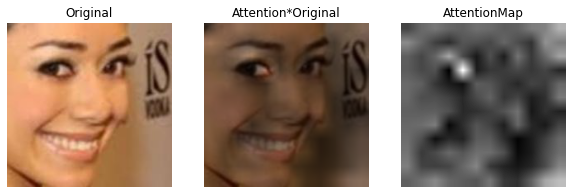

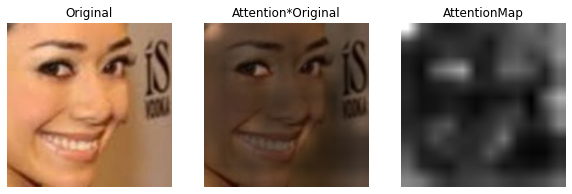

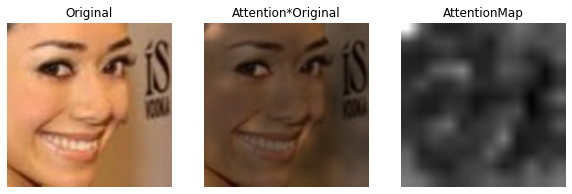

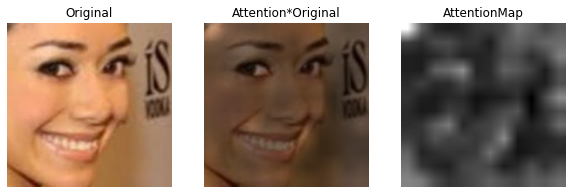

In [32]:
IND_SAMPLE = 100
IND_TRANSFORMER_LAYER_NUM_LIST = [0, 3, 7, 11]

(
    input_inference_tensor,
    input_show_tensor,
    ind_class_true,
) = get_inference_show_data_sample(dataset_dict, IND_SAMPLE)

show_attentions_and_prediction(
    model,
    input_inference_tensor,
    ind_class_true,
    input_show_tensor,
    IND_TRANSFORMER_LAYER_NUM_LIST,
)

As we can see the attention for the final layers of the transformer becomes more focused on the parts of the face important for gender classification.

Let us now look across all various data samples to see which parts of the face ViT finds important

Real label: female | Prediction: female : 0.99205 male : 0.00795 

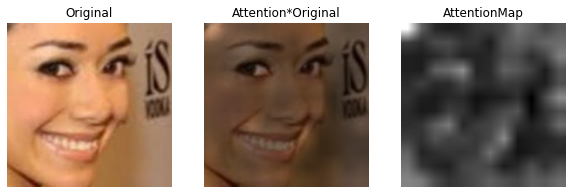

Real label: male | Prediction: male : 0.95067 female : 0.04933 

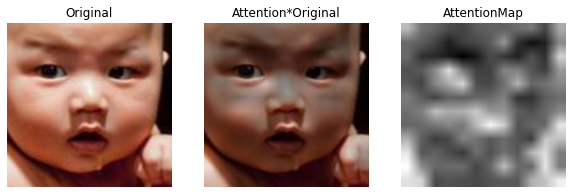

Real label: male | Prediction: male : 0.99955 female : 0.00045 

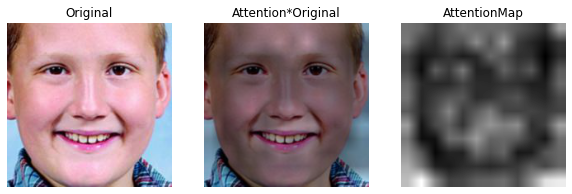

Real label: male | Prediction: female : 0.59514 male : 0.40486 

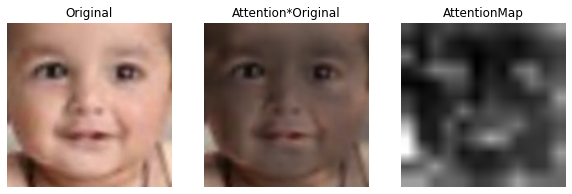

Real label: female | Prediction: female : 0.99407 male : 0.00593 

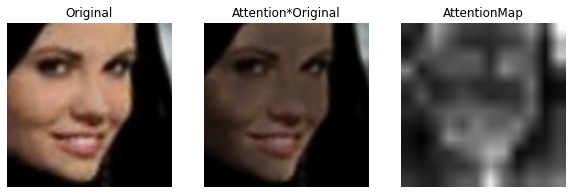

Real label: female | Prediction: female : 0.99774 male : 0.00226 

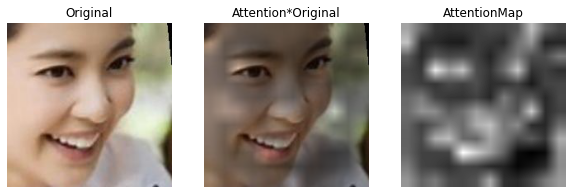

Real label: female | Prediction: female : 0.99884 male : 0.00116 

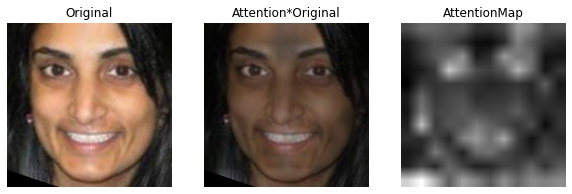

Real label: female | Prediction: female : 0.99841 male : 0.00159 

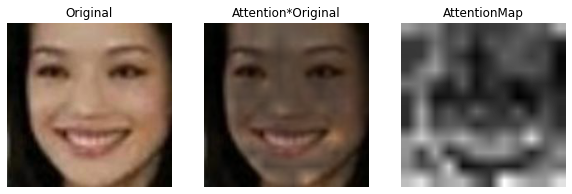

Real label: male | Prediction: male : 0.99248 female : 0.00752 

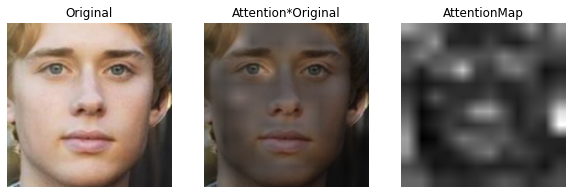

Real label: female | Prediction: female : 0.99767 male : 0.00233 

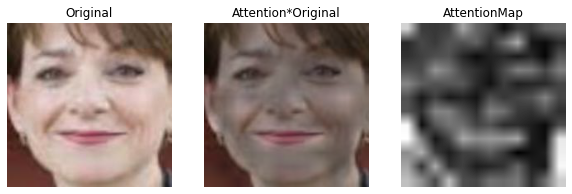

In [33]:
IND_SAMPLE_VEC = np.arange(100, 120, 2)
IND_TRANSFORMER_LAYER_NUM_LIST = [11]

for ind_sample in IND_SAMPLE_VEC:
    (
        input_inference_tensor,
        input_show_tensor,
        ind_class_true,
    ) = get_inference_show_data_sample(dataset_dict, ind_sample)

    show_attentions_and_prediction(
        model,
        input_inference_tensor,
        ind_class_true,
        input_show_tensor,
        IND_TRANSFORMER_LAYER_NUM_LIST,
    )

### Attention analysis: conclusion

The attention maps shown above provide sufficient ground to say that ViT is good at detecting 
 - the "building blocks" of a face such as eyes, nose, mouths, hair and exactly these face elements ViT finds important
 - face position (as eyes, nose, mouse and face edges are detected regardless of face position and orientation)

## Position embedding analysis

Let us define a few functions for 
 - extracting both image patch and <cls> patch positional embeddings from the model
 - calculating cosine similarity between the embeddings

In [34]:
def extract_patch_and_cls_pos_embedding_mat(model):
    patch_grid_size_list = [
        math.floor(IMAGE_SIZE / s) for s in model.patch_embedding.stride
    ]

    pos_emb_mat = model.positional_embedding.pos_embedding.squeeze(0)

    n_patches = pos_emb_mat.shape[0] - 1

    assert patch_grid_size_list[0] * patch_grid_size_list[1] == n_patches

    patch_pos_emb_mat = pos_emb_mat[1:, :]
    cls_pos_emb = pos_emb_mat[0:1, :]
    return patch_pos_emb_mat, cls_pos_emb, patch_grid_size_list

In [35]:
def sim_matrix(a, b, eps=1e-8):
    # Cosine similarity
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

In [36]:
def calc_embedding_cossim_grid(patch_pos_emb_mat, patch_grid_size_list):
    patch_pos_emb_sim_mat = sim_matrix(patch_pos_emb_mat, patch_pos_emb_mat)

    patch_pos_emb_sim_mat.max()
    n_patches = patch_grid_size_list[0] * patch_grid_size_list[1]
    grid_tensor = torchvision.utils.make_grid(
        patch_pos_emb_sim_mat.reshape([n_patches, 1] + patch_grid_size_list),
        nrow=patch_grid_size_list[0],
    ).detach()
    #
    # torchvision.utils.make_grid always generates RGB image
    # even if number of color channges in the input images is 1
    # in such cases we can safely ignore all color channels but the first one
    # because they are all equal:
    #
    assert torch.allclose(grid_tensor[0, :, :], grid_tensor[1, :, :])
    assert torch.allclose(grid_tensor[0, :, :], grid_tensor[2, :, :])
    #
    return grid_tensor[0:1, :, :]

In [37]:
def calc_pos_emb_stats(model, new_model, model_descr, new_model_descr):
    (
        patch_pos_emb_mat,
        cls_pos_emb,
        patch_grid_size_list,
    ) = extract_patch_and_cls_pos_embedding_mat(model)
    (
        new_patch_pos_emb_mat,
        new_cls_pos_emb,
        new_patch_grid_size_list,
    ) = extract_patch_and_cls_pos_embedding_mat(new_model)
    assert patch_grid_size_list == new_patch_grid_size_list
    grid_sim_mat = calc_embedding_cossim_grid(patch_pos_emb_mat, patch_grid_size_list)
    new_grid_sim_mat = calc_embedding_cossim_grid(
        new_patch_pos_emb_mat, patch_grid_size_list
    )
    grid_diff_of_sim_mat = new_grid_sim_mat - grid_sim_mat
    patch_pos_emb_diff_mat = new_patch_pos_emb_mat - patch_pos_emb_mat

    grid_sim_of_diff_mat = calc_embedding_cossim_grid(
        patch_pos_emb_diff_mat, patch_grid_size_list
    )
    cls_vs_patch_pos_emb_sim_mat = (
        sim_matrix(cls_pos_emb, patch_pos_emb_mat)
        .reshape(patch_grid_size_list)
        .unsqueeze(0)
        .detach()
    )
    new_cls_vs_patch_pos_emb_sim_mat = (
        sim_matrix(new_cls_pos_emb, new_patch_pos_emb_mat)
        .reshape(patch_grid_size_list)
        .unsqueeze(0)
        .detach()
    )

    max_rel_patch_pos_emb_diff_of_sim = (
        2
        * grid_diff_of_sim_mat.abs().max()
        / (new_grid_sim_mat.abs().mean() + grid_sim_mat.abs().mean())
    )

    max_rel_patch_pos_emb_diff = (
        2
        * patch_pos_emb_diff_mat.abs().max()
        / (new_patch_pos_emb_mat.abs().mean() + patch_pos_emb_mat.abs().mean())
    )

    max_rel_cls_pos_emb_diff = (
        2
        * (new_cls_pos_emb - cls_pos_emb).abs().max()
        / (new_cls_pos_emb.abs().mean() + cls_pos_emb.abs().mean())
    )

    stats_dict = {
        "grid_sim_mat": grid_sim_mat,
        "new_grid_sim_mat": new_grid_sim_mat,
        "grid_diff_of_sim_mat": grid_diff_of_sim_mat,
        "grid_sim_of_diff_mat": grid_sim_of_diff_mat,
        "cls_vs_patch_pos_emb_sim_mat": cls_vs_patch_pos_emb_sim_mat,
        "new_cls_vs_patch_pos_emb_sim_mat": new_cls_vs_patch_pos_emb_sim_mat,
        "max_rel_patch_pos_emb_diff": max_rel_patch_pos_emb_diff * 100,
        "max_rel_patch_pos_emb_diff_of_sim": max_rel_patch_pos_emb_diff_of_sim * 100,
        "max_rel_cls_pos_emb_diff": max_rel_cls_pos_emb_diff * 100,
        "max_cls_vs_patch_pos_emb_sim": cls_vs_patch_pos_emb_sim_mat.abs().max(),
        "max_new_cls_vs_patch_pos_emb_sim": new_cls_vs_patch_pos_emb_sim_mat.abs().max(),
    }
    stats_descr_dict = {
        "grid_sim_mat": f"Patch pos. emb. cosine sim. for {model_descr}",
        "new_grid_sim_mat": f"Patch pos. emb. cosone sim. for {new_model_descr}",
        "grid_diff_of_sim_mat": "Difference of cosine sim. matrices for patch emb.",
        "grid_sim_of_diff_mat": "Cosine sim. of pos. emb. differences for patch emb",
        "cls_vs_patch_pos_emb_sim_mat": f"Cosine sim. between cls and patch emb. for {model_descr}",
        "new_cls_vs_patch_pos_emb_sim_mat": f"Cosine sim. between cls and patch emb. for {new_model_descr}",
        "max_rel_patch_pos_emb_diff": "Max. percentage relative difference of patch pos. emb.",
        "max_rel_patch_pos_emb_diff_of_sim": "Max. percentage relative diff of cosine sim. for patch pos. emb.",
        "max_rel_cls_pos_emb_diff": "Max. percentage relative difference of cls pos. emb.",
        "max_cls_vs_patch_pos_emb_sim": f"Max. cosine sim. between cls and patch pos. emb. for {model_descr}",
        "max_new_cls_vs_patch_pos_emb_sim": f"Max. cosine sim. between cls and patch pos. emb. for {new_model_descr}",
    }
    return stats_dict, stats_descr_dict

In [38]:
model_orig_pretrained = pytorch_pretrained_vit.ViT(
    "B_16_imagenet1k", image_size=IMAGE_SIZE, pretrained=True
).to(DEVICE)

Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])
Loaded pretrained weights.


In [39]:
pos_emb_stats_dict, pos_emb_stats_descr_dict = calc_pos_emb_stats(
    model_orig_pretrained, model, "pretrained (B_16_imagenet1k)", "finetuned (UTKFaces)"
)

In [40]:
def show_pos_emb_matrix_report(
    pos_emb_stats_dict, pos_emb_stats_descr_dict, field_list, figsize
):
    tensor_list, tensor_descr_list = zip(
        *[[pos_emb_stats_dict[k], pos_emb_stats_descr_dict[k]] for k in field_list]
    )
    show_image_tensors(tensor_list, tensor_descr_list, figsize=figsize, max_cols=2)

In [41]:
def show_pos_emb_stats_report(pos_emb_stats_dict, pos_emb_stats_descr_dict):
    FIG_SIZE = (15, 15)
    matrix_field_list = [
        k for k in pos_emb_stats_dict if ("grid" in k and "_mat" in k)
    ] + [k for k in pos_emb_stats_dict if ("cls" in k and "_mat" in k)]
    show_pos_emb_matrix_report(
        pos_emb_stats_dict, pos_emb_stats_descr_dict, matrix_field_list, FIG_SIZE
    )
    rest_scalar_field_list = [
        k for k in pos_emb_stats_dict if k not in matrix_field_list
    ]

    for field_name in rest_scalar_field_list:
        field_descr = pos_emb_stats_descr_dict[field_name]
        field_value = pos_emb_stats_dict[field_name]
        print(f"{field_descr}: {field_value: .2f}")

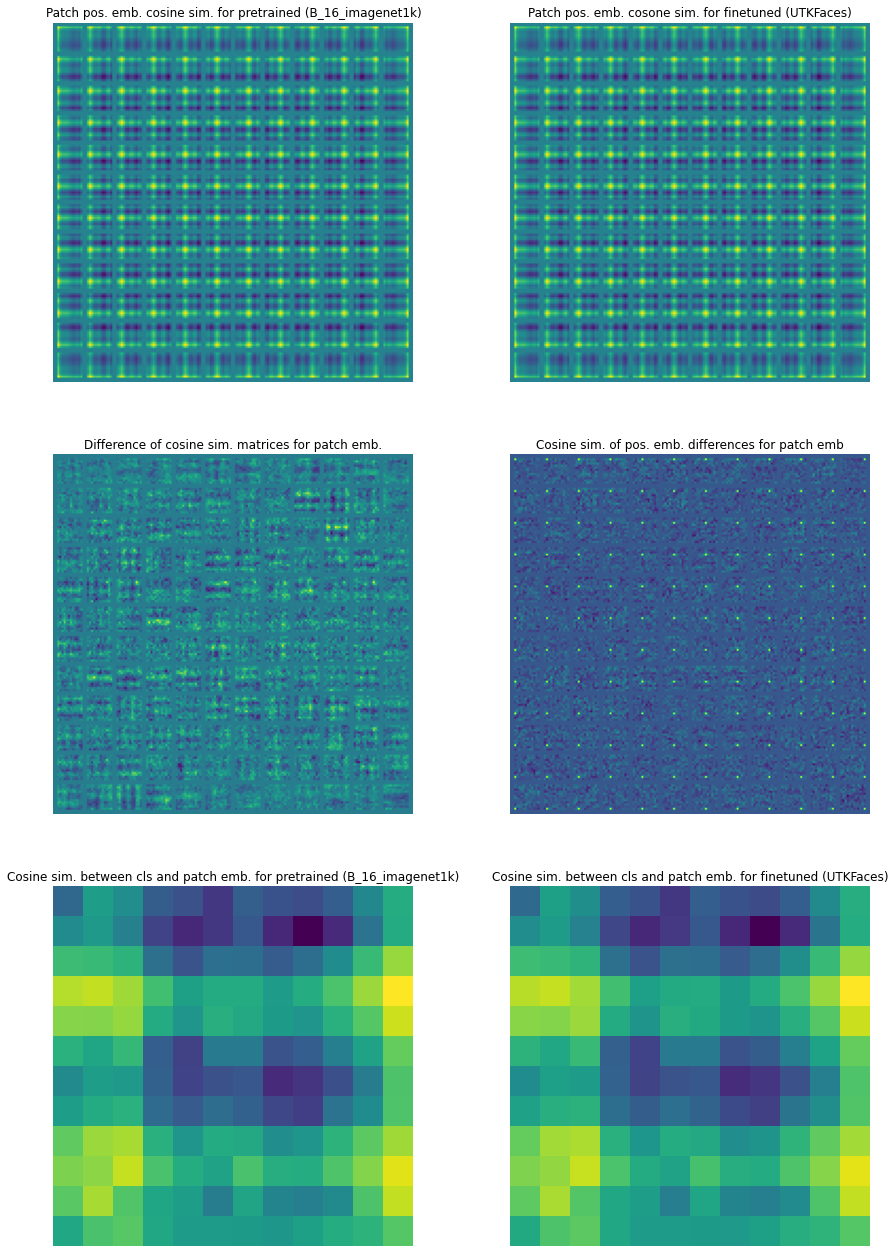

Max. percentage relative difference of patch pos. emb.:  2.43
Max. percentage relative diff of cosine sim. for patch pos. emb.:  1.21
Max. percentage relative difference of cls pos. emb.:  3.61
Max. cosine sim. between cls and patch pos. emb. for pretrained (B_16_imagenet1k):  0.09
Max. cosine sim. between cls and patch pos. emb. for finetuned (UTKFaces):  0.09


In [42]:
show_pos_emb_stats_report(pos_emb_stats_dict, pos_emb_stats_descr_dict)

### Position embedding analysis: conclusion

We were able to reproduce the results from [[3]](#3) showing that positional embeddings definitely hold positional information. This is clearly visible from the first two graphs with cells of light green "crosses". The presence of the "crosses" means that positional embeddings are more tightly related to posiitonal embeddings of positionally closer patches.

As we can see the maximum absolute difference between similarity matrices of the two embeddings is less than 1% of the average level of both the original pre-trained and the fine-tuned positional embedding similaritiy matrices. 

The maximum absolute differece of embeddings is less than 2.5% of of the average level of both the original and the fine-tuned embeddings.

The graphs above show that the differences are not systematic. This, combined with the low values of relative differences gives us sufficient ground to conclude that the positional information inside the positional embeddings is mostly preserved during the fine-tuning process.

The low value of maximum percentage relative difference of cls positional embedding indicates that fine-tuning did change cls positional embedding much. The low values of maximum cosine similarity values between cls and match positional embeddings for both the pre-trained and fine-tuned models clearly indicates that cls positional embeddings is easily distinguishable from all patch positional embeddings.

The regular pattern of cosine similarity matrix between cls positional embedding and patch positional embedding (though the absolute values of cosine similarity are low) is a result of regular structure of patch positional embeddings.

## References

[1] "Attention Is All You Need", Ashish Vaswani and Noam Shazeer and Niki Parmar and Jakob Uszkoreit and Llion Jones and Aidan N. Gomez and Lukasz Kaiser and Illia Polosukhin,
      2017,
      [arXiv/1706.03762](https://arxiv.org/abs/1706.03762)
    
[2] "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks", Mingxing Tan and Quoc V. Le, 2020,  [arXiv/1905.11946](https://arxiv.org/abs/1905.11946)

[3]. "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", Alexey Dosovitskiy and Lucas Beyer and Alexander Kolesnikov and Dirk Weissenborn and Xiaohua Zhai and Thomas Unterthiner and Mostafa Dehghani and Matthias Minderer and Georg Heigold and Sylvain Gelly and Jakob Uszkoreit and Neil Houlsby, 2020, [arXiv/2010.11929](https://arxiv.org/abs/2010.11929)

[4] [Vision Transformer](https://github.com/google-research/vision_transformer) GitHub repo with original implementation of Vision Transformer in Jax by Google

[5]  [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch) GitHub project

[6] [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) GitHub project